In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/src')
from src import *
import cmocean.cm as cm
import matplotlib.tri as tri


In [ ]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

### Request HPC Resources

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.58:40460 --name dummy-name --nthreads 36 --memory-limit 93.13GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.58:40460,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [ ]:
def read_CM4X(fname): 
    ds = xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
    
    ds = ds.drop(["lat", "lon"])
    ds = ds.rename({"geolat":"lat", "geolon":"lon"})
    ds = approximate_z(ds)
    ds = ds[["thetao", "so", "z", "thkcello"]]
    ds = ds.where(ds.thkcello > 1e-9)
    return ds

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/" + x
ds = read_CM4X(datadir("model/yearly_output_0.25deg/CM4Xp125_historical_transient_tracers.zarr"))
ds_ctrl = read_CM4X(datadir("model/yearly_output_0.25deg/CM4Xp125_piControl_transient_tracers.zarr"))
ds_ctrl = ds_ctrl.isel(year = slice(None, 165))

In [ ]:

interp_ctrl_timeseries.coords['year'] = interp_hist_timeseries.coords['year']

In [8]:
def zonal_average(ds, var):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds[var] * weights).sum(["xh"]) / weights.sum(["xh"])
    return weighted_ds

def get_zonal_sigma_average(ds): 
    ds_zonal = zonal_average(get_sigma2(ds), "sigma2").compute().rename("sigma2")
    ds_zonal["z"] = zonal_average(ds, "z").compute()
    ds_zonal = ds_zonal.to_dataset()
    ds_zonal["lat"] = zonal_average(ds, "lat").compute()
    ds_zonal = interpolate_section(ds_zonal, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "yh")

    return ds_zonal

In [7]:
ds = ds.mean("year").compute()
ds_ctrl = ds_ctrl.mean("year").compute()

In [9]:
ds_zonal = get_zonal_sigma_average(ds)
ds_ctrl_zonal = get_zonal_sigma_average(ds_ctrl)

(-80.0, 0.0)

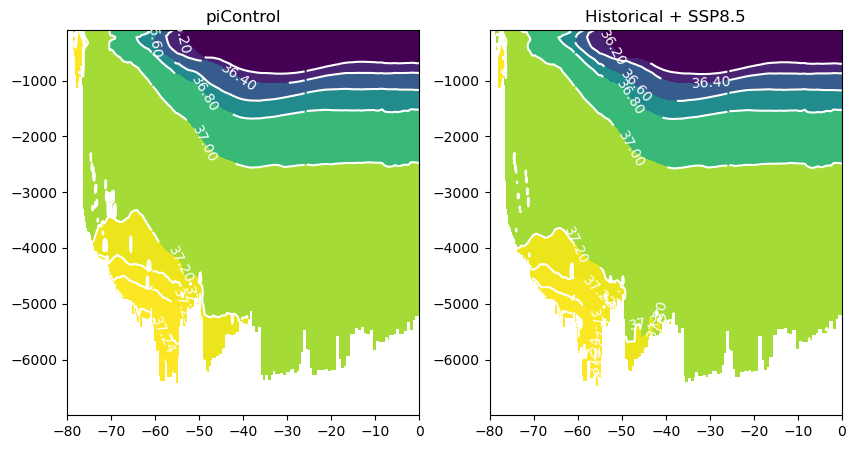

In [12]:
lat = ds_zonal.lat.mean("z")

siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.append(siglevels, [37.22, 37.23, 37.24])

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ax = axes[0]; ax.set_title("piControl")
ax.contourf(ds_ctrl_zonal.yh, ds_ctrl_zonal.z, ds_ctrl_zonal.sigma2, levels = siglevels, extend = "both")
ax.contour(ds_ctrl_zonal.yh[:120], ds_ctrl_zonal.z, ds_ctrl_zonal.sigma2[:, :120], levels = siglevels, colors = "white")
CS = ax.contour(ds_ctrl_zonal.yh[120:220], ds_ctrl_zonal.z, ds_ctrl_zonal.sigma2[:, 120:220], levels = siglevels, colors = "white")
ax.contour(ds_ctrl_zonal.yh[220:], ds_zonal.z, ds_ctrl_zonal.sigma2[:, 220:], levels = siglevels, colors = "white")
plt.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(-80, 0)

ax = axes[1]; ax.set_title("Historical + SSP8.5")
ax.contourf(ds_zonal.yh, ds_zonal.z, ds_zonal.sigma2, levels = siglevels, extend = "both")
ax.contour(ds_zonal.yh[:120], ds_zonal.z, ds_zonal.sigma2[:, :120], levels = siglevels, colors = "white")
CS = ax.contour(ds_zonal.yh[120:220], ds_zonal.z, ds_zonal.sigma2[:, 120:220], levels = siglevels, colors = "white")
ax.contour(ds_zonal.yh[220:], ds_zonal.z, ds_zonal.sigma2[:, 220:], levels = siglevels, colors = "white")
plt.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(-80, 0)

In [9]:
ds_zonal = zonal_average(get_sigma2(ds), "sigma2").compute().rename("sigma2")
ds_zonal["z"] = zonal_average(ds, "z").compute()
ds_zonal = ds_zonal.to_dataset()
ds_zonal["lat"] = zonal_average(ds, "lat").compute()
ds_zonal = interpolate_section(ds_zonal, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "yh")

In [10]:
ds_ctrl_zonal = zonal_average(get_sigma2(ds_ctrl), "sigma2").compute().rename("sigma2")
ds_ctrl_zonal["z"] = zonal_average(ds_ctrl, "z").compute()
ds_ctrl_zonal = ds_ctrl_zonal.to_dataset()
ds_ctrl_zonal["lat"] = zonal_average(ds_ctrl, "lat").compute()
ds_ctrl_zonal = interpolate_section(ds_ctrl_zonal, -np.arange(100, 7000), interp_coord = "z", iterate_coord = "yh")

(-80.0, 0.0)

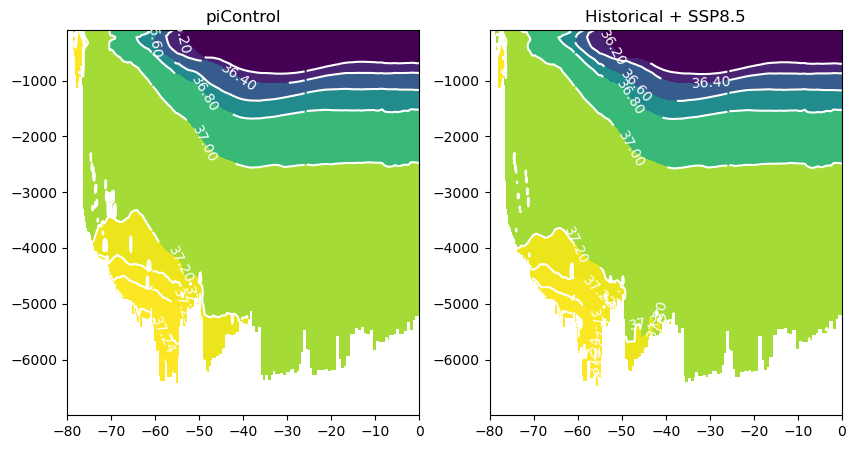

In [46]:
import matplotlib.tri as tri

lat = ds_zonal.lat.mean("z")

siglevels = np.arange(36.2, 37.4, .2) 
siglevels = 1.0 * np.append(siglevels, [37.22, 37.23, 37.24])

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

ax = axes[0]; ax.set_title("piControl")
ax.contourf(ds_ctrl_zonal.yh, ds_ctrl_zonal.z, ds_ctrl_zonal.sigma2, levels = siglevels, extend = "both")
ax.contour(ds_ctrl_zonal.yh[:120], ds_ctrl_zonal.z, ds_ctrl_zonal.sigma2[:, :120], levels = siglevels, colors = "white")
CS = ax.contour(ds_ctrl_zonal.yh[120:220], ds_ctrl_zonal.z, ds_ctrl_zonal.sigma2[:, 120:220], levels = siglevels, colors = "white")
ax.contour(ds_ctrl_zonal.yh[220:], ds_zonal.z, ds_ctrl_zonal.sigma2[:, 220:], levels = siglevels, colors = "white")
plt.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(-80, 0)

ax = axes[1]; ax.set_title("Historical + SSP8.5")
ax.contourf(ds_zonal.yh, ds_zonal.z, ds_zonal.sigma2, levels = siglevels, extend = "both")
ax.contour(ds_zonal.yh[:120], ds_zonal.z, ds_zonal.sigma2[:, :120], levels = siglevels, colors = "white")
CS = ax.contour(ds_zonal.yh[120:220], ds_zonal.z, ds_zonal.sigma2[:, 120:220], levels = siglevels, colors = "white")
ax.contour(ds_zonal.yh[220:], ds_zonal.z, ds_zonal.sigma2[:, 220:], levels = siglevels, colors = "white")
plt.clabel(CS, inline=1, fontsize=10)
ax.set_xlim(-80, 0)

In [12]:
def flat_average(ds, var):
    weights = ds.thkcello * ds.areacello
    weighted_ds = (ds[var] * weights).sum(["zl"]) / weights.sum(["zl"])
    return weighted_ds

In [38]:
ds_out = xe.util.grid_global(0.25, 0.25)

ds_flat = flat_average(get_sigma2(ds).where(ds.z > -500), "sigma2").compute().rename("sigma2")
ds_flat["lat"] = ds["lat"]
ds_flat["lon"] = ds["lon"]

regridder = xe.Regridder(ds_flat, ds_out, "bilinear", periodic=True)
ds_flat = regridder(ds_flat)

ds_ctrl_flat = flat_average(get_sigma2(ds_ctrl).where(ds.z > -500), "sigma2").compute().rename("sigma2")
ds_ctrl_flat["lat"] = ds_ctrl_flat["lat"]
ds_ctrl_flat["lon"] = ds_ctrl_flat["lon"]

regridder = xe.Regridder(ds_ctrl_flat, ds_out, "bilinear", periodic=True)
ds_ctrl_flat = regridder(ds_ctrl_flat)

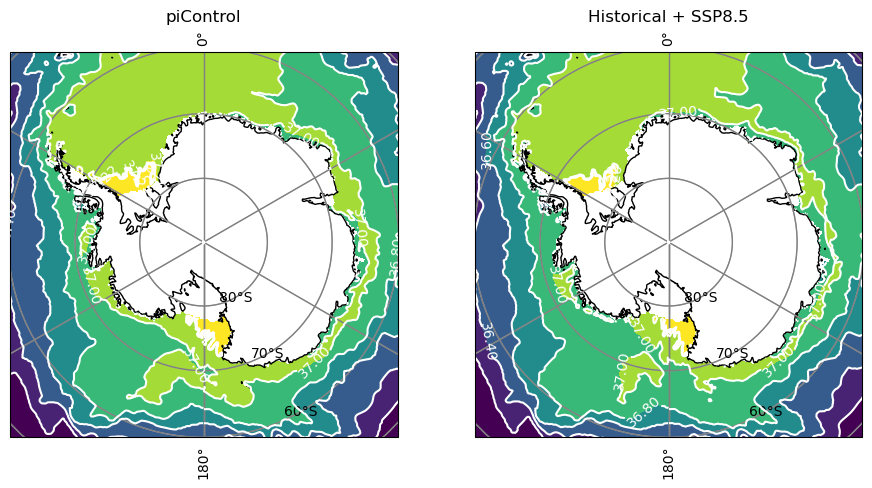

In [39]:
fig, axs = plt.subplots(1, 2,
                        subplot_kw={'projection': ccrs.SouthPolarStereo()},
                        figsize=(11,8.5))
[a.set_extent([-180, 180, -90, -60], ccrs.PlateCarree()) for a in axs]
axs[0].set_title("piControl")
axs[1].set_title("Historical + SSP8.5")

for (i, data) in enumerate([ds_ctrl_flat, ds_flat]):
    axs[i].coastlines();
    axs[i].gridlines();
    gls = axs[i].gridlines(draw_labels=True, crs=ccrs.PlateCarree(), lw=1, color="gray")

    axs[i].contourf(data.lon, data.lat, data, transform=ccrs.PlateCarree(), levels = siglevels, extend = "both")
    CS = axs[i].contour(data.lon, data.lat, data, transform=ccrs.PlateCarree(), levels = siglevels, colors = "white")
    plt.clabel(CS, inline=1, fontsize=10)